<br>
<br>
<h2>Purpose</h2>
<br>
<hr>
A notebook to develop an AI system aiming at trading intraday on cryptocurrencies
<br>
<br>

<br>
<br>
<h2>Imports</h2>
<br>
<hr>
<br>

In [1]:
# Pandas and Python
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import time

# Graphic Libraries
import plotly.io as pio
pio.templates.default = "simple_white"
pio.renderers.default = "notebook"
import matplotlib.pyplot as plt
from IPython.display import clear_output

# AI and stats
import statsmodels.api as sm
import xgboost
from xgboost import XGBRegressor
import sklearn

# Multiprocessing
from functools import partial
from multiprocessing import Pool
from threadpoolctl import threadpool_limits



<br>
<br>
<h2>Notebook Parameters</h2>
<br>
<hr>
<br>

In [2]:
# Define data path
data_path = "in_sample/"

# Risk free rate assumption
risk_free_rate = 0.05 # % per year
rfr_hourly = (1 + risk_free_rate)**(1 / (24*365)) - 1

# Suggested training set
start_date_train = "2023-01-24"
last_date_train = "2024-01-24"

# Suggested validation set
start_date_validate = "2024-01-25"
last_date_validate = "2024-07-24"

# Test set (Unavailable)
# start_date_test = "2024-07-25"
# last_date_test = "2025-01-24"

# Maximum number of features to use
max_nb_features = 60

# Random seed for feature selection
random_seed = 0

# Set a level of transaction costs
tc = 0.0000

# Set the percentage of engineered features to use
pct_engineered_features = 0.25


<br>
<br>
<h2>Data Loading</h2>
<br>
<hr>
<br>

In [3]:
# Main data
data = pd.read_csv(
    f"{data_path}data_in_sample.csv",
    index_col=0,
    header=[0,1],
)

# Make sure that the index is in the right format
data.index = pd.to_datetime(data.index)


<h4>Features</h4>
Continue to use a simple first batch of features
<br>

In [4]:
simple_features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

# Iterate over some interesting fields to create features
for field in [
    "return",
    "close",
    "nb_trades",
    "volume_usd",
    "funding_rate",
    "open_interest_value"
]:
    print(f"Make features using raw field {field}")

    # Extract raw data
    raw_data = data[field]

    # Create raw feature
    for feature_style in [
        "level",
        "delta_1",
        "delta_6",
        "shift_1",
        "shift_3",
        "shift_6",
        "shift_24",
        "mean_6",
        "mean_24",
        "mean_120",
        "std_6",
        "std_24",
        "std_120",
        "skew_6",
        "skew_24",
        "skew_120",
        "kurt_6",
        "kurt_24",
        "kurt_120",
    ]:

        # Level
        if feature_style == "level":
            raw_feature = raw_data

        # Delta 1
        if feature_style == "delta_1":
            raw_feature = raw_data.pct_change(1, fill_method=None)

        # Delta 6
        if feature_style == "delta_6":
            raw_feature = raw_data.pct_change(6, fill_method=None)

        # Shift 1
        if feature_style == "shift_1":
            raw_feature = raw_data.shift(1)

        # Shift 3
        if feature_style == "shift_3":
            raw_feature = raw_data.shift(3)

        # Shift 6
        if feature_style == "shift_6":
            raw_feature = raw_data.shift(6)

        # Shift 24
        if feature_style == "shift_24":
            raw_feature = raw_data.shift(24)

        # Mean 6
        if feature_style == "mean_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,1).mean()

        # Mean 24
        if feature_style == "mean_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,1).mean()

        # Mean 120
        if feature_style == "mean_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,1).mean()

        # Std 6
        if feature_style == "std_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,2).std()

        # Std 24
        if feature_style == "std_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,2).std()

        # Std 120
        if feature_style == "std_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,2).std()

        # Skew 6
        if feature_style == "skew_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,3).skew()

        # Skew 24
        if feature_style == "skew_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,3).skew()

        # Skew 120
        if feature_style == "skew_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,3).skew()

        # Kurtosis 6
        if feature_style == "kurt_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,4).kurt()

        # Kurtosis 24
        if feature_style == "kurt_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,4).kurt()

        # Kurtosis 120
        if feature_style == "kurt_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,4).kurt()


        # Stack and store feature
        raw_feature = raw_feature.stack().reindex(simple_features.index)
        simple_features[f"{field}_{feature_style}"] = raw_feature



Make features using raw field return
Make features using raw field close
Make features using raw field nb_trades
Make features using raw field volume_usd
Make features using raw field funding_rate
Make features using raw field open_interest_value


<br>
Also use a certain percentage of engineered features
<br>
<br>

In [5]:
# Load engineered features
engineered_features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

for dirpath, dirnames, filenames in os.walk(data_path):

    # Only keep standard features for the moment
    filenames = [i for i in filenames if "feature" in i]

    # Select a random list of features (always the same)
    np.random.seed(random_seed)
    subset_filenames = np.random.choice(
        a=filenames,
        size=min(int(max_nb_features*pct_engineered_features), len(filenames)),
        replace=False,
    )
    for filename in subset_filenames:

        print(f"Loading {filename}")

        # Load feature
        feature = pd.read_csv(
            f"{data_path}{filename}",
            index_col=0,
            header=[0],
        )

        # Make sure that the index is in the right format
        feature.index = pd.to_datetime(feature.index)

        # Store in the feature dict
        engineered_features[filename.replace(".csv", "")] = feature.stack().reindex(
            engineered_features.index)


Loading feature_669028663444.csv
Loading feature_272923323412.csv
Loading feature_603841450314.csv
Loading feature_034613324449.csv
Loading feature_723195992091.csv
Loading feature_644984534227.csv
Loading feature_349700183501.csv
Loading feature_360363963222.csv
Loading feature_757966399344.csv
Loading feature_163039513711.csv
Loading feature_764560493700.csv
Loading feature_217884298030.csv
Loading feature_597112414582.csv
Loading feature_576016642244.csv
Loading feature_881677815989.csv


### Additional feature engineering

In [6]:
features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

# Add your existing simple features
np.random.seed(random_seed)
subset_simple_features = np.random.choice(
    a=list(simple_features.keys()),
    size=min(int(max_nb_features*(1-pct_engineered_features)), len(simple_features.keys())),
    replace=False,
)

for feature_name in subset_simple_features:
    features[feature_name] = simple_features[feature_name]

# Add your existing engineered features
for feature_name in engineered_features:
    features[feature_name] = engineered_features[feature_name]

# ========= 1. REGIME FEATURES =========
print("1. Creating regime features...")

vol_24h = data["return"].rolling(24).std()
vol_threshold = vol_24h.rolling(24*7).quantile(0.7)
high_vol = (vol_24h > vol_threshold).astype(int)
features["regime_high_vol"] = high_vol.stack().reindex(features.index)

mom_24h = data["return"].rolling(24).sum()
mom_threshold = mom_24h.rolling(24*7).quantile(0.7)
trending = (mom_24h.abs() > mom_threshold.abs()).astype(int)
features["regime_trend"] = trending.stack().reindex(features.index)

print(f"   Added: 2 regime features")

# ========= 2. MARKET MICROSTRUCTURE =========
print("2. Creating microstructure features...")

spread_proxy = data["return"].rolling(6).std() / (data["volume_usd"].rolling(6).mean() + 1e-8)
features["spread_proxy_6h"] = spread_proxy.stack().reindex(features.index)

volume_momentum = data["volume_usd"].pct_change(6, fill_method=None)
features["volume_momentum_6h"] = volume_momentum.stack().reindex(features.index)

price_vol_corr = data["return"].rolling(24).corr(data["volume_usd"].pct_change(1, fill_method=None))
features["price_volume_corr_24h"] = price_vol_corr.stack().reindex(features.index)

trade_intensity = data["nb_trades"].rolling(6).sum() / (data["nb_trades"].rolling(24).sum() + 1e-8)
features["trade_intensity_ratio"] = trade_intensity.stack().reindex(features.index)

print(f"   Added: 4 microstructure features")

# ========= 3. CROSS-ASSET =========
print("3. Creating cross-asset features...")

market_avg_return = data["return"].mean(axis=1)
relative_return = data["return"].sub(market_avg_return, axis=0)
features["relative_return_1h"] = relative_return.stack().reindex(features.index)

asset_market_corr = data["return"].T.rolling(24).corr(data["return"].mean(axis=1)).T
features["market_corr_24h"] = asset_market_corr.stack().reindex(features.index)

return_rank = data["return"].rank(axis=1, pct=True)
features["return_rank_1h"] = return_rank.stack().reindex(features.index)

cross_vol = data["return"].std(axis=1)
features["cross_sectional_vol"] = cross_vol.reindex(features.index.get_level_values(0)).values

print(f"   Added: 4 cross-asset features")

# ========= 4. TIME-OF-DAY =========
print("4. Creating time-based features...")

n_assets = len(data["return"].columns)

hour = data.index.hour              # this is a numpy array / Index
hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)

features["hour_sin"] = pd.Series(
    np.repeat(hour_sin, n_assets),
    index=features.index,
)
features["hour_cos"] = pd.Series(
    np.repeat(hour_cos, n_assets),
    index=features.index,
)

day_of_week = data.index.dayofweek  # numpy array / Index again
dow_sin = np.sin(2 * np.pi * day_of_week / 7)
dow_cos = np.cos(2 * np.pi * day_of_week / 7)

features["dow_sin"] = pd.Series(
    np.repeat(dow_sin, n_assets),
    index=features.index,
)
features["dow_cos"] = pd.Series(
    np.repeat(dow_cos, n_assets),
    index=features.index,
)

is_weekend = (day_of_week >= 5).astype(int)
features["is_weekend"] = pd.Series(
    np.repeat(is_weekend, n_assets),
    index=features.index,
)

print(f"   Added: 5 time-based features")

# ========= 5. ADVANCED REGIMES =========
print("5. Creating advanced regime features...")

rolling_mean_24h = data["return"].rolling(24).mean()
distance_from_mean = (data["return"] - rolling_mean_24h) / (data["return"].rolling(24).std() + 1e-8)
features["mean_reversion_score"] = distance_from_mean.stack().reindex(features.index)

vol_low = (vol_24h < vol_24h.rolling(24*7).quantile(0.33)).astype(int)
vol_high = (vol_24h > vol_24h.rolling(24*7).quantile(0.67)).astype(int)
features["regime_vol_low"] = vol_low.stack().reindex(features.index)
features["regime_vol_high"] = vol_high.stack().reindex(features.index)

mom_strength = mom_24h.abs() / (data["return"].rolling(24).std() + 1e-8)
features["momentum_strength"] = mom_strength.stack().reindex(features.index)

up_streak = (data["return"] > 0).rolling(6).sum()
features["up_streak_6h"] = up_streak.stack().reindex(features.index)

print(f"   Added: 5 advanced regime features")

# ========= 6. FUNDING RATE DYNAMICS =========
print("6. Creating funding rate features...")

funding_delta_6h = data["funding_rate"].diff(6)
features["funding_delta_6h"] = funding_delta_6h.stack().reindex(features.index)

funding_zscore = (data["funding_rate"] - data["funding_rate"].rolling(24*7).mean()) / (data["funding_rate"].rolling(24*7).std() + 1e-8)
features["funding_zscore"] = funding_zscore.stack().reindex(features.index)

oi_change = data["open_interest_value"].pct_change(6, fill_method=None)
features["oi_change_6h"] = oi_change.stack().reindex(features.index)

print(f"   Added: 3 funding rate features")


1. Creating regime features...
   Added: 2 regime features
2. Creating microstructure features...
   Added: 4 microstructure features
3. Creating cross-asset features...
   Added: 4 cross-asset features
4. Creating time-based features...
   Added: 5 time-based features
5. Creating advanced regime features...
   Added: 5 advanced regime features
6. Creating funding rate features...
   Added: 3 funding rate features


<br>
Putting all features together
<br>
<br>

In [7]:
# NOTE: This cell is commented out to preserve the features created in the previous cell
# (which includes simple + engineered + 23 custom features).
# Feature selection will be done in the next cell to reach exactly 60 features.

# # Aggregate engineered and simple features all together
# features = pd.DataFrame(
#     np.nan,
#     index=data["return"].stack().index,
#     columns=[],
# )

# # Select a random list of simple features (always the same)
# np.random.seed(random_seed)
# subset_simple_features = np.random.choice(
#     a=list(simple_features.keys()),
#     size=min(int(max_nb_features*(1-pct_engineered_features)),
#              len(simple_features.keys())),
#     replace=False,
# )

# for feature_name in subset_simple_features:

#     features[feature_name] = simple_features[feature_name]

# for feature_name in engineered_features:

#     features[feature_name] = engineered_features[feature_name]

print(f"Features before selection: {len(features.columns)}")
print(f"Features shape: {features.shape}")

Features before selection: 83
Features shape: (5405472, 83)


Instead of doing random subset of features, we can choose feature more deliberately after consulting the top feature lists after running XGB model.

In [8]:
# Deliberate feature selection: top features + random fill to reach 60 total
# Best features identified from previous XGB runs
top_features_base = [
    "open_interest_value_mean_6",
    "funding_rate_skew_24",
    "close_shift_6",
    "close_mean_6",
    "close_shift_1",
    "funding_rate_shift_24",
    "close_std_24",
    "volume_usd_mean_120",
    "open_interest_value_std_24",
    "return_delta_6",
    "volume_usd_std_24",
    "volume_usd_kurt_6",
    "nb_trades_skew_6",
    "funding_rate_kurt_120",
    "return_kurt_6",
    "funding_rate_skew_120",
    "nb_trades_std_120",
    "open_interest_value_std_6",
    "volume_usd_skew_24",
    "feature_811799367203",
    "close_skew_24",
    "open_interest_value_kurt_120",
    "funding_rate_skew_6",
    "return_skew_6",
    "volume_usd_delta_6",
    "feature_479883256457",
    "feature_004212234751",
    "funding_rate_kurt_24",
    "return_shift_1",
    "feature_447214984470",
]

# Keep only those top features that exist in the current feature set
present_top = [f for f in top_features_base if f in features.columns]

# Target 60 features total
target_n = 60
n_random = max(0, target_n - len(present_top))

# Remaining features not in top list
remaining = [c for c in features.columns if c not in present_top]

# Randomly select additional features to reach 60 (using the same seed)
np.random.seed(random_seed)
random_extra = list(np.random.choice(
    remaining,
    size=min(n_random, len(remaining)),
    replace=False,
))

# Combine: top features first, then random extras
final_features = present_top + random_extra

print(f"Top features (present): {len(present_top)}")
print(f"Random extras: {len(random_extra)}")
print(f"Total in final_features: {len(final_features)}")

# Filter features to only include the selected ones
features = features[final_features].copy()
print(f"\nAfter deliberate selection: {features.shape}")

Top features (present): 26
Random extras: 34
Total in final_features: 60

After deliberate selection: (5405472, 60)


In [9]:
print(f"Total features: {len(features.columns)}")

Total features: 60


<br>
<br>
<h2>Analytics</h2>
<br>
<hr>
Basic Portfolio analytics to invest in some predictions of the future instruments returns
<br>
<br>


In [10]:
def expected_returns_to_positions(expected_returns):
    """
    Normalize expected returns to make it an investable portfolio

    :param expected_returns: pd.DataFrame containing expectations
                             about future instruments prices variations
    """

    # Positions will be proportional to ranked alpha
    positions = expected_returns.rank(axis=1)

    # Re-scale the leverage
    positions = positions.div(positions.abs().sum(axis=1), axis=0)

    # Make the portfolio dollar neutral
    positions = positions.sub(positions.mean(axis=1), axis=0)

    return positions


def get_sharpe(pnl_portfolio, rfr_hourly):
    """
    Compute the sharpe ratio

    :param pnl_portfolio: pd.Series of returns of the portfolio considered
    :param rfr_hourly: float, the hourly risk free rate
    """

    # Compute excess returns
    excess_returns = pnl_portfolio - rfr_hourly

    # Compute sharpe ratio
    sharpe_ratio = (
        excess_returns.mean() / excess_returns.std() * np.sqrt(24 * 365)
    )

    # Output
    return round(sharpe_ratio, 2)


def pnl_analytics(positions,
                  returns,
                  rfr_hourly,
                  lag,
                  tc=0):
    """
    Compute the p&l analytics of the strategy

    :param positions: pd.DataFrame, some positions that have been reached
    :param returns: pd.DataFrame containing returns of instruments
    :param rfr_hourly: float, the hourly risk free rate
    :param lag: int, the number of hours to reach the positions
    :param tc: float, the transaction costs

    """

    # Compute gross p&l
    pnl = positions.shift(1+lag).mul(returns).sum(axis=1)

    # Compute transaction costs
    trades = positions.fillna(0).diff()
    costs = trades.abs().sum(axis=1) * tc

    # Net p&l: deduce costs from gross p&l
    pnl = pnl.sub(costs, fill_value=0)

    # Compute sharpe
    sharpe = get_sharpe(pnl, rfr_hourly)

    return {"sharpe": sharpe,
           "pnl": pnl}


def analyze_expected_returns(
    expected_returns,
    returns,
    rfr_hourly,
    title = "a Nice Try",
    lags = [0,1,2,3,6,12],
    tc = 0,
    plot_option="matplotlib",
    output_stats=False,
):
    """
    Provide an economic analysis of some expected_returns

    :param expected_returns: pd.DataFrame containing expectations
                             about future instruments prices variations
    :param returns: pd.DataFrame containing returns of instruments
    :param rfr_hourly: float, the hourly risk free rate
    :param lags: list of int, corresponding to the number of hours to
                 reach the positions
    :param tc: float, the transaction costs
    :param plot_option: str, the library used to display the cumulative
                        p&l plot, can be "plotly" or "matplotlib"
    :param output_stats: boolean, wheter or not to output basic portfolio
                         statistics
    """

    # Take positions as a function of expected returns
    positions = expected_returns_to_positions(expected_returns)

    # Compute p&l and sharpe for different lags
    pnl_lags = {}
    for lag in lags:
        analytics_lag = pnl_analytics(
            positions=positions,
            returns=returns,
            rfr_hourly=rfr_hourly,
            lag=lag,
            tc=tc)
        lag_label = f"Lag {lag}, sharpe={analytics_lag['sharpe']}"
        pnl_lags[lag_label] = analytics_lag["pnl"]

    # Compute cumulative returns
    pnl_lags = pd.concat(pnl_lags, axis=1).dropna()
    cumulative_pnl_lags = (1+pnl_lags).cumprod().resample("24h").last()

    # Display
    if plot_option == "plotly":

        pd.options.plotting.backend = "plotly"

        fig = cumulative_pnl_lags.plot(
            title=f"Cumulative returns of {title}",
        )
        fig.update_layout(yaxis_type="log")
        fig.show()

    elif plot_option == "matplotlib":

        pd.options.plotting.backend = "matplotlib"

        ax = cumulative_pnl_lags.plot(
            title=f"Cumulative returns of {title}",
            logy=True,
            grid=False,
            figsize=(10, 4),
        )
        plt.show()

    else:
        raise ValueError("plot_option must be either 'plotly' or 'matplotlib'")

    # Output statistics if requested
    if output_stats:

        statistics = {}

        # Compute turnover
        turnover = positions.fillna(0).diff().abs().sum(axis=1).mean()
        statistics["turnover"] = round(turnover * 24, 2) # standardize the turnover to be daily

        # Compute sharpe
        statistics["sharpe"] = pnl_analytics(
            positions=positions,
            returns=returns,
            rfr_hourly=rfr_hourly,
            lag=lags[0],
            tc=tc,
        )["sharpe"]

        return pd.Series(statistics).to_frame("Statistics").T



<br>
<br>
<h2>Features Standard Pre-Processing</h2>
<br>
<hr>

<br>
We experimented with multi-horizon prediction


In [11]:
label = data["return"].loc[start_date_train:last_date_train
    ].shift(-1).stack()

In [12]:
# Define multiple prediction horizons (1h, 3h, 6h, 12h)
horizons = {
    "1h": 1,
    "3h": 3,
    "6h": 6,
    "12h": 12,
}

# Create labels for each horizon
labels_by_horizon = {}

for horizon_name, h in horizons.items():
    # Cumulative return over h hours
    label_horizon = data["return"].rolling(h).sum().shift(-h).stack()
    
    # Keep only dates in training range
    label_horizon = label_horizon.loc[start_date_train:last_date_train]
    
    labels_by_horizon[horizon_name] = label_horizon
    
    print(f"  - {horizon_name}: {len(label_horizon)} samples")

print("="*60)


  - 1h: 3600771 samples
  - 3h: 3600771 samples
  - 6h: 3600771 samples
  - 12h: 3600771 samples


In [13]:
features_normalized = pd.DataFrame().reindex_like(features)

for feature_name in features.keys():

    print(f"Pre-processing {feature_name}")

    # Extract the feature
    feature_normalized = features[feature_name].unstack()

    # Rank the feature to remove outliers
    feature_normalized = feature_normalized.rank(axis=1, pct=True) - 0.5

    # Stack the feature
    feature_normalized = feature_normalized.stack().reindex(
        features_normalized.index
    )

    # Store this normalized version
    features_normalized[feature_name] = feature_normalized

# Replace NaNs by average values, as OLS cannot handle NaNs effectively
features_normalized = features_normalized.fillna(0)

# Only keep datetimes that are common between the label and the features
# for training
common_index = label.index.intersection(features_normalized.index)
features_normalized_train = features_normalized.reindex(common_index)
label = label.reindex(common_index)


Pre-processing open_interest_value_mean_6
Pre-processing funding_rate_skew_24
Pre-processing close_shift_6
Pre-processing close_mean_6
Pre-processing close_shift_1
Pre-processing funding_rate_shift_24
Pre-processing close_std_24
Pre-processing volume_usd_mean_120
Pre-processing open_interest_value_std_24
Pre-processing return_delta_6
Pre-processing volume_usd_std_24
Pre-processing volume_usd_kurt_6
Pre-processing nb_trades_skew_6
Pre-processing funding_rate_kurt_120
Pre-processing return_kurt_6
Pre-processing funding_rate_skew_120
Pre-processing nb_trades_std_120
Pre-processing open_interest_value_std_6
Pre-processing volume_usd_skew_24
Pre-processing close_skew_24
Pre-processing open_interest_value_kurt_120
Pre-processing funding_rate_skew_6
Pre-processing return_skew_6
Pre-processing volume_usd_delta_6
Pre-processing funding_rate_kurt_24
Pre-processing return_shift_1
Pre-processing regime_trend
Pre-processing regime_high_vol
Pre-processing market_corr_24h
Pre-processing feature_75796

<br>
<br>
<h2>XGBoost: Gradient Boosted Decision Trees</h2>
<br>
<hr>
Gradient Boosted Decision Trees are another way to introduce non-linearity in our model. This non-linearity is present in the link between the label and features, but also among the features themselves. Overfitting is limited thanks to a variety of strategies, resulting in potentially better generalization.
<br>
<br>


<br>
<h4>Defining hyper-parameters</h4>
<br>



In [14]:
# Define hyperparameters
hyperparameters = {
    "learning_rate": 0.001,
    "n_estimators": 500,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "base_score": 0,
    "max_depth": 7,
    "min_child_weight": 10,
    "subsample": 0.05,
    "colsample_bytree": 0.3,
    "min_split_loss": 0,
    "reg_lambda": 1,
    "reg_alpha": 0,
    "n_jobs": 1,
    "random_state": 0,
}

<br>
<h4>Training the models</h4>
<br>



Add booster to check feature importance

Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00

Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

Train a model from date 2022-09-05 00:00:00 to date 2023-08-31 00:00:00
Predict from date 2023-08-31 01:00:00 to date 2023-10-01 00:00:00

Train a model from date 2022-10-05 00:00:00 to date 2023-09-30 00:00:00
Predict from date 2023-09-30 01:00:00 to date 2023-10-31 00:00:00

Train a model from date 202

f26   0.0032
f30   0.0031
f48   0.0031
f1    0.0031
f49   0.0030
f0    0.0030
f27   0.0030
f44   0.0029
f36   0.0029
f10   0.0029
f59   0.0029
f7    0.0028
f39   0.0028
f52   0.0028
f17   0.0028
f8    0.0028
f6    0.0028
f5    0.0028
f38   0.0027
f16   0.0027
f4    0.0027
f2    0.0027
f3    0.0027
f58   0.0026
f55   0.0026
f32   0.0026
f54   0.0026
f14   0.0026
f18   0.0026
f13   0.0026
f42   0.0026
f41   0.0026
f11   0.0026
f15   0.0026
f12   0.0026
f9    0.0026
f31   0.0026
f20   0.0026
f22   0.0026
f33   0.0026
f23   0.0026
f51   0.0026
f34   0.0025
f25   0.0025
f19   0.0025
f53   0.0025
f46   0.0025
f29   0.0024
f57   0.0024
f45   0.0024
dtype: float64

Total Training time is 761.4071350097656 seconds


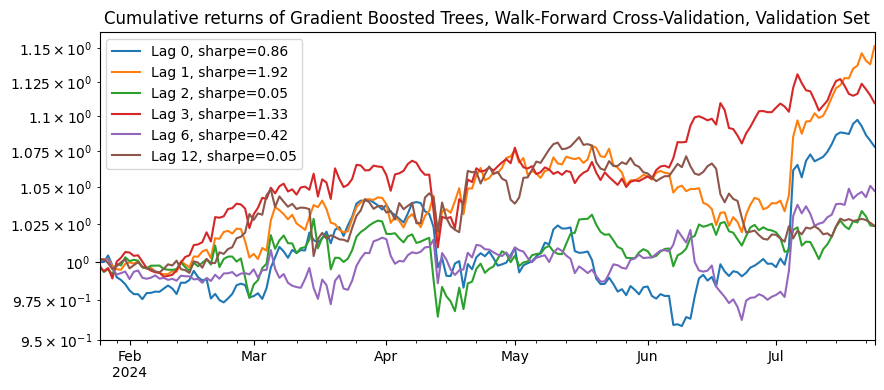

In [15]:
# Measure time
t1 = time.time()

# Recompute the model every month, skip the first 2 months
rebalancing_dates = pd.date_range(
    start=start_date_train,
    end=last_date_validate,
    freq="ME"
)[2:]

def train_predict_period(
    last_date_train_fold,
    returns,
    hyperparameters,
):

    # Force the usage of a single core inside of the function,
    # to avoid nested multiprocessing attempts
    with threadpool_limits(limits=1):

        # Define training and validation dates

        # Train the model over the last X months
        start_date_train_fold = last_date_train_fold - pd.Timedelta(days = 30 * 12)

        # The model cannot be used before the first hour following the training
        # (no look-forward bias)
        start_date_validate_fold = last_date_train_fold + pd.Timedelta(hours = 1)

        # The trained model will be used for 1 month
        last_date_validate_fold = last_date_train_fold + pd.Timedelta(days = 31 * 1)

        # Log informations
        print(f"Train a model from date {start_date_train_fold} to date {last_date_train_fold}")
        print(f"Predict from date {start_date_validate_fold} to date {last_date_validate_fold}")
        print("")


        # Create label
        label_fold = returns.loc[start_date_train_fold:last_date_train_fold
            ].shift(-1).stack()

        features_train_raw = features_normalized.reindex(label_fold.index)

        # mask: finite label AND all finite features
        mask = (
            np.isfinite(label_fold.values)
            & np.isfinite(features_train_raw).all(axis=1).values
        )

        label_fold = label_fold[mask] # mask to keep only rows with finite label and features
        features_normalized_train_fold = features_train_raw[mask]
        # Only keep dates of the train and validation sets for the features
        #features_normalized_train_fold = features_normalized.reindex(label_fold.index)
        features_normalized_validate_fold = features_normalized.sort_index().loc[
            start_date_validate_fold:last_date_validate_fold]

        # Split the data along the time axis
        ts_splitter = sklearn.model_selection.TimeSeriesSplit(n_splits=5)

        # Create model
        model = XGBRegressor(**hyperparameters)

        # Fit model
        model = model.fit(
            y=label_fold,
            X=features_normalized_train_fold,
        )

        # Feature importance
        booster = model.get_booster()
        fscore = booster.get_score(importance_type="gain")  # dict: {feature_name: gain}

        importance_gain = (
        pd.Series(fscore, name=str(last_date_train_fold))
        .sort_values(ascending=False)
        )

        # Predict on the validation set
        predictions = model.predict(
            features_normalized_validate_fold)
        predictions = pd.Series(
            predictions,
            index=features_normalized_validate_fold.index
        ).unstack()

        # Output results
        return (pd.concat({str(last_date_train_fold) : predictions}, axis=1), 
                importance_gain)
    

# Fix all but one function parameters to iterate on the last one
partial_train_predict_period = partial(
    train_predict_period,
    returns=data["return"],
    hyperparameters=hyperparameters,
)

# Train using one core per date
predictions = []
importances = [] # feature importance
for date in rebalancing_dates:
    pred, imp = train_predict_period(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters  # or model parameters
    )
    predictions.append(pred)
    importances.append(imp)

# Reformat predictions
predictions = pd.concat(predictions, axis=1).T.groupby(level=1).sum().T
importance_df = pd.concat(importances, axis=1).fillna(0)
importance_mean = importance_df.mean(axis=1).sort_values(ascending=False)

print("Top 50 features by average gain across folds:")
display(importance_mean.head(50))

# Remove extra zeros added in the process, as we don't want to take positions
# if there was no prediction
predictions = predictions.replace(0, np.nan)

# Remove empty and invalid dates
predictions = predictions.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"Total Training time is {t2-t1} seconds")

# Analyse our predictions
analyze_expected_returns(
    expected_returns=predictions.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"Gradient Boosted Trees, Walk-Forward Cross-Validation, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,

)

### XGB for multi-horizon


TRAINING XGBOOST FOR HORIZON: 1H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00

Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-30

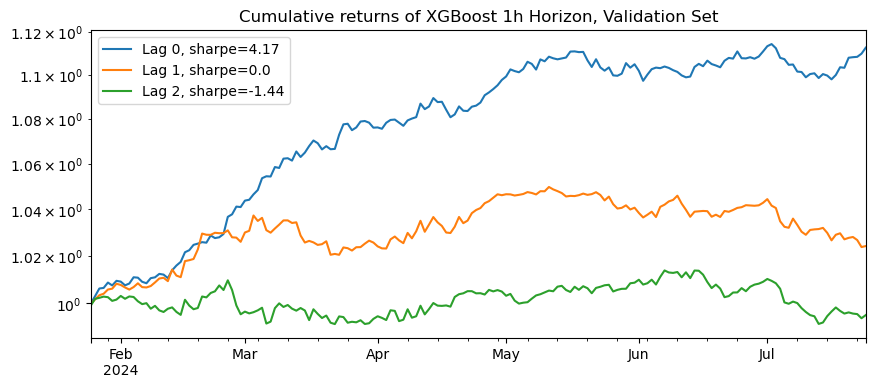


TRAINING XGBOOST FOR HORIZON: 3H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00

Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-30

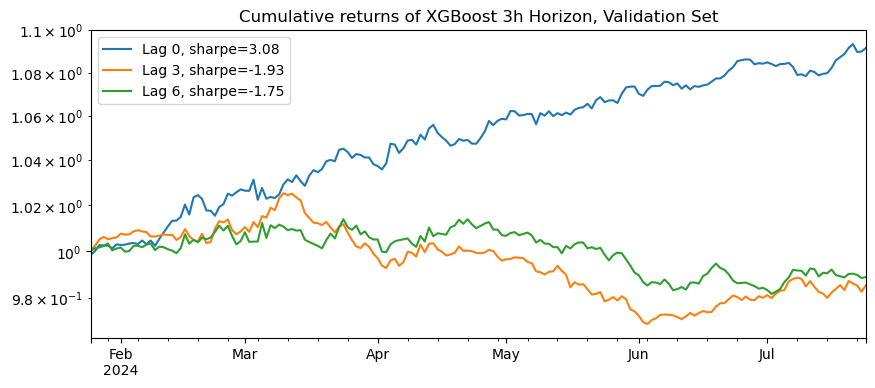


TRAINING XGBOOST FOR HORIZON: 6H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00

Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-30

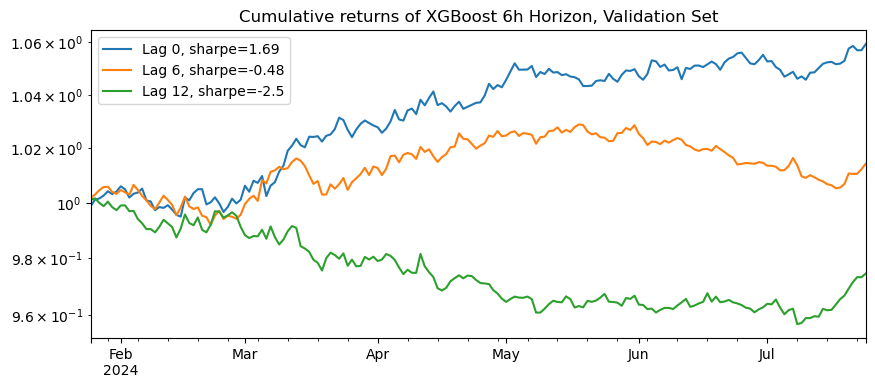


TRAINING XGBOOST FOR HORIZON: 12H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00

Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-3

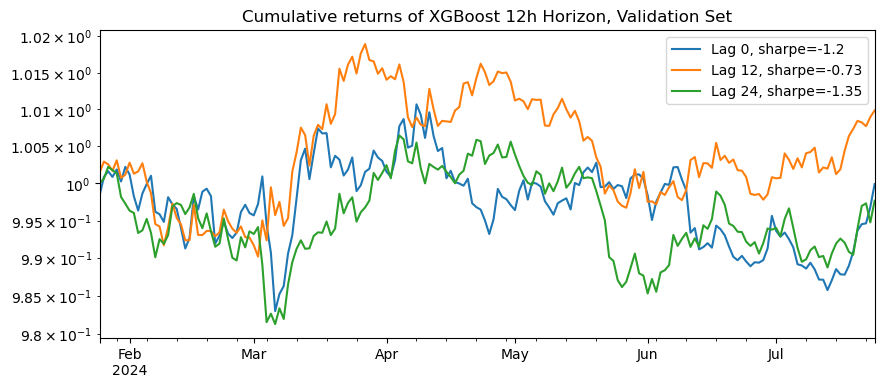

In [14]:
# Hyperparameters (keep th existing ones)
# Rebalancing dates
rebalancing_dates = pd.date_range(
    start=start_date_train,
    end=last_date_validate,
    freq="ME",
)[2:]

# Store predictions for each horizon
predictions_by_horizon = {}

# ===== LOOP OVER HORIZONS =====
for horizon_name, h in horizons.items():
    
    print(f"\n{'='*60}")
    print(f"TRAINING XGBOOST FOR HORIZON: {horizon_name.upper()}")
    print(f"{'='*60}\n")
    
    # Get label for this horizon
    label = labels_by_horizon[horizon_name]
    
    # Only keep common datetimes between label and features
    common_index = label.index.intersection(features_normalized.index)
    featuresnormalized_train = features_normalized.reindex(common_index)
    label_train = label.reindex(common_index)
    
    # Training loop (walk-forward cross-validation)
    t1 = time.time()
    
    predictions_list = []
    
    for date in rebalancing_dates:
        
        # Define fold dates
        start_date_train_fold = date - pd.Timedelta(days=30*12)
        start_date_validate_fold = date + pd.Timedelta(hours=1)
        last_date_validate_fold = date + pd.Timedelta(days=31)
        
        print(f"Train from {start_date_train_fold} to {date}")
        print(f"Predict from {start_date_validate_fold} to {last_date_validate_fold}\n")
        
        # Create label for this fold
        label_fold = label_train.loc[start_date_train_fold:date]
        
        # Features for train and validation
        features_train_fold = featuresnormalized_train.reindex(label_fold.index)
        features_validate_fold = features_normalized.loc[
            start_date_validate_fold:last_date_validate_fold
        ]
        
        # Train XGBoost
        with threadpool_limits(limits=1):
            model = XGBRegressor(**hyperparameters)
            model.fit(
                X=features_train_fold,
                y=label_fold,
            )
            
            # Predict
            pred = model.predict(features_validate_fold)
            pred = pd.Series(pred, index=features_validate_fold.index).unstack()
            
            predictions_list.append(
                pd.concat({str(date): pred}, axis=1)
            )
    
    # Reformat predictions
    predictions = pd.concat(predictions_list, axis=1).T.groupby(level=1).sum().T
    predictions = predictions.replace(0, np.nan).dropna(axis=0, how='all')
    
    t2 = time.time()
    print(f"\nTotal training time for {horizon_name}: {t2-t1:.1f} seconds")
    
    # Store predictions
    predictions_by_horizon[horizon_name] = predictions
    
    # Analyze this horizon
    print(f"\n{'='*60}")
    print(f"RESULTS FOR HORIZON: {horizon_name.upper()}")
    print(f"{'='*60}")
    
    analyze_expected_returns(
        expected_returns=predictions.loc[start_date_validate:last_date_validate],
        returns=data["return"].loc[start_date_validate:last_date_validate],
        rfr_hourly=rfr_hourly,
        title=f"XGBoost {horizon_name} Horizon, Validation Set",
        lags=[0, h, h*2],  # Use horizon-specific lags
        tc=tc,
    )


Then we ensemble across horizons

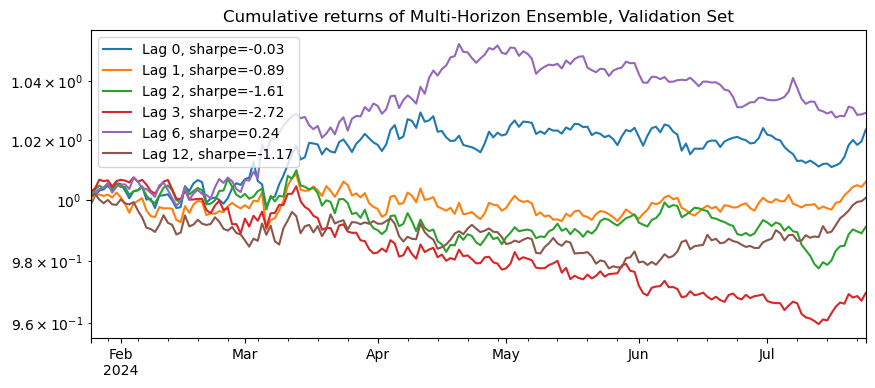

In [15]:
# Simple averaging ensemble
predictions_ensemble = (
    predictions_by_horizon["1h"] +
    predictions_by_horizon["3h"] +
    predictions_by_horizon["6h"] +
    predictions_by_horizon["12h"]
) / 4

# Analyze ensemble
analyze_expected_returns(
    expected_returns=predictions_ensemble.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title="Multi-Horizon Ensemble, Validation Set",
    lags=[0, 1, 2, 3, 6, 12],
    tc=tc,
)


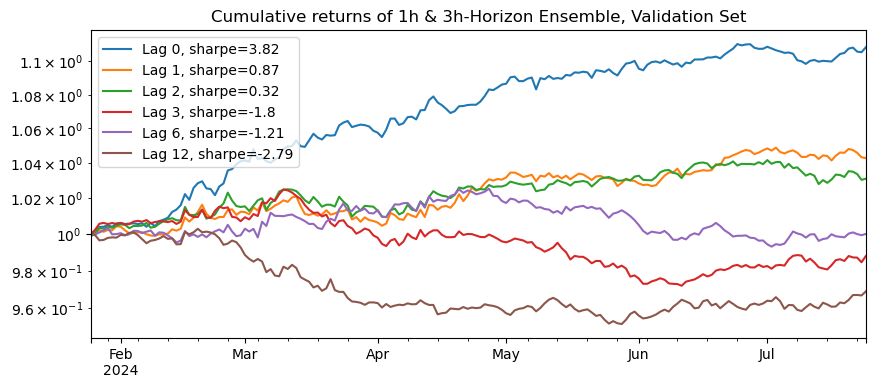

In [17]:
# veraging ensemble between 1h and 3h horizons, which are more similar and have better performance than the 6h and 12h horizons
predictions_ensemble = (
    predictions_by_horizon["1h"] +
    predictions_by_horizon["3h"] 
) / 2

# Analyze ensemble
analyze_expected_returns(
    expected_returns=predictions_ensemble.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title="1h & 3h-Horizon Ensemble, Validation Set",
    lags=[0, 1, 2, 3, 6, 12],
    tc=tc,
)